In [44]:
# 这块是经过精简的文件 titanic_data.ipynb 的代码，保留后面需要的数据处理部分
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 导入数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 数据合并
full = pd.concat([train, test], ignore_index=True)

# 数据清洗与填充缺失值
full['Cabin'] = full['Cabin'].fillna('U')
full['Embarked'] = full['Embarked'].fillna('S')
price = full[(full['Pclass'] == 3) & (full['Embarked'] == 'S') & (full['Cabin'] == 'U')]['Fare'].mean()
full['Fare'] = full['Fare'].fillna(price)
full['Fare'] = full['Fare'].map(lambda x: np.log(x) if x > 0 else x)

# 构造新特征
full['FamilyNum'] = full['SibSp'] + full['Parch'] + 1
full['Title'] = full['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
TitleDict = {
    'Mr': 'Mr', 'Mlle': 'Miss', 'Miss': 'Miss', 'Master': 'Master', 'Jonkheer': 'Master',
    'Mme': 'Mrs', 'Ms': 'Mrs', 'Mrs': 'Mrs', 'Don': 'Royalty', 'Sir': 'Royalty',
    'the Countess': 'Royalty', 'Dona': 'Royalty', 'Lady': 'Royalty', 'Capt': 'Officer',
    'Col': 'Officer', 'Major': 'Officer', 'Dr': 'Officer', 'Rev': 'Officer'
}
full['Title'] = full['Title'].map(TitleDict)

agePre = full[['Age', 'Parch', 'Pclass', 'SibSp', 'FamilyNum', 'Title']]
agePre = pd.get_dummies(agePre)
ageKnown = agePre[agePre['Age'].notnull()]
ageUnknown = agePre[agePre['Age'].isnull()]

ageKnown_X = ageKnown.drop(['Age'], axis=1)
ageKnown_y = ageKnown['Age']
ageUnknown_X = ageUnknown.drop(['Age'], axis=1)

rfr = RandomForestRegressor(random_state=None, n_estimators=500, n_jobs=-1)
rfr.fit(ageKnown_X, ageKnown_y)
ageUnknown_predict = rfr.predict(ageUnknown_X)
full.loc[(full['Age'].isnull()), 'Age'] = ageUnknown_predict

full['FamilySize'] = full['FamilyNum'].map(lambda x: 0 if x == 1 else 1 if 2 <= x <= 4 else 2)
full['Desk'] = full['Cabin'].map(lambda x: x[0])
TickCountDict = full['Ticket'].value_counts()
full['TickCom'] = full['Ticket'].map(TickCountDict)
full['TickGroup'] = full['TickCom'].map(lambda x: 0 if 2 <= x <= 4 else 1 if x == 1 or 5 <= x <= 8 else 2)
full['Surname'] = full['Name'].map(lambda x: x.split(',')[0].strip())
SurNameDict = full['Surname'].value_counts()
full['SurnameNum'] = full['Surname'].map(SurNameDict)

# 同组识别与数据修正
MaleDf = full[(full['Age'] >= 12) & (full['Sex'] == 'male') & (full['FamilyNum'] >= 2)]
MSurNameDf = MaleDf.dropna(subset=['Survived']).groupby('Surname')['Survived'].mean()
FemChildDf = full[((full['Sex'] == 'female') | (full['Age'] <= 12)) & (full['FamilyNum'] >= 2)]
FCSurNameDf = FemChildDf.dropna(subset=['Survived']).groupby('Surname')['Survived'].mean()
MSurNameDict = MSurNameDf[MSurNameDf.values == 1].index
FCSurNameDict = FCSurNameDf[FCSurNameDf.values == 0].index

full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(MSurNameDict)) & (full['Sex'] == 'male'), 'Sex'] = 'female'
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(MSurNameDict)) & (full['Sex'] == 'male'), 'Age'] = 5
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(FCSurNameDict)) & (full['Sex'] == 'female') & (full['Age'] <= 12), 'Sex'] = 'male'
full.loc[(full['Survived'].isnull()) & (full['Surname'].isin(FCSurNameDict)) & (full['Sex'] == 'female') & (full['Age'] <= 12), 'Age'] = 60

# 特征选择
fullSel = full.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'Surname', 'SurnameNum'], axis=1)
fullSel = fullSel.drop(['Parch', 'SibSp'], axis=1)
fullSel = pd.get_dummies(fullSel)

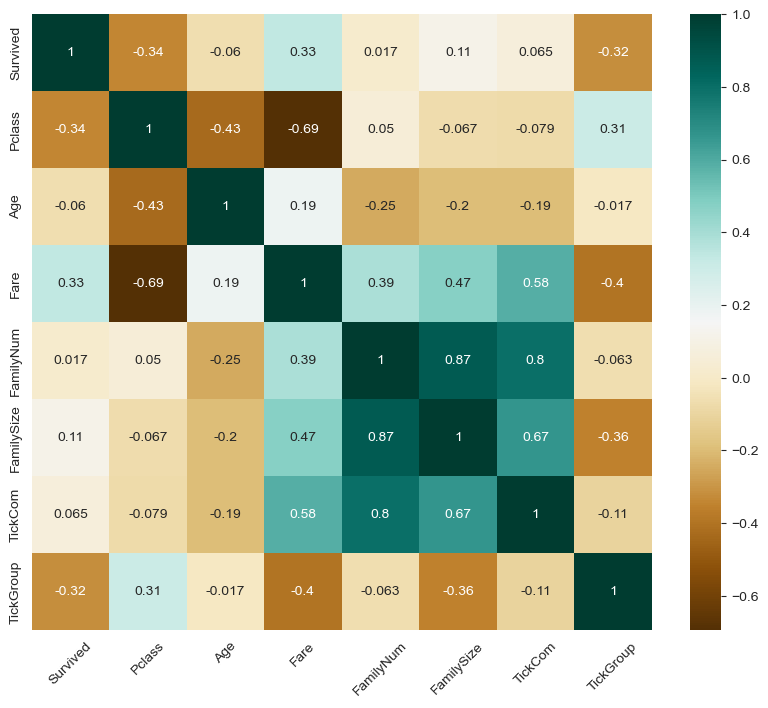

In [45]:
# 验证上方数据处理代码无错
plt.figure(figsize=(10, 8))
sns.heatmap(fullSel.select_dtypes(include=['number']).corr(), cmap='BrBG', annot=True)
_ = plt.xticks(rotation=45)

In [46]:
 # 拆分实验数据与预测数据
experData = fullSel[fullSel['Survived'].notnull()] # 已有数据
preData = fullSel[fullSel['Survived'].isnull()] # 预测数据

experData_X = experData.drop('Survived', axis=1)
experData_y = experData['Survived']

preData_X = preData.drop('Survived', axis=1) # 空数据

# 导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# 设置 kfold，交叉采样法拆分数据集
kfold = StratifiedKFold(n_splits=10)

# 汇总不同模型算法
classifiers = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(),
               GradientBoostingClassifier(), KNeighborsClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), XGBClassifier()]

In [47]:
# 不同机器学习交叉验证结果汇总
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, experData_X, experData_y, scoring='accuracy', cv=kfold, n_jobs=-1))

# 求出模型得分的均值和标准差
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# 汇总数据
cvResDf = pd.DataFrame({'cv_mean': cv_means, 'cv_std': cv_std, 'algorithm': ['SVC', 'DecisionTreeCla', 'RandomForestCla', 'ExtraTreesCla', 'GradientBoostingCla', 'KNN', 'LR', 'LDA', 'XGBC']})

display(cvResDf)

,cv_mean,cv_std,algorithm
0,0.762110,0.054994,SVC
1,0.773321,0.047700,DecisionTreeCla
2,0.815993,0.045820,RandomForestCla
3,0.804707,0.038692,ExtraTreesCla
4,0.831685,0.048826,GradientBoostingCla
5,0.796891,0.033632,KNN
6,0.827216,0.040262,LR
7,0.828327,0.032288,LDA
8,0.814869,0.045007,XGBC


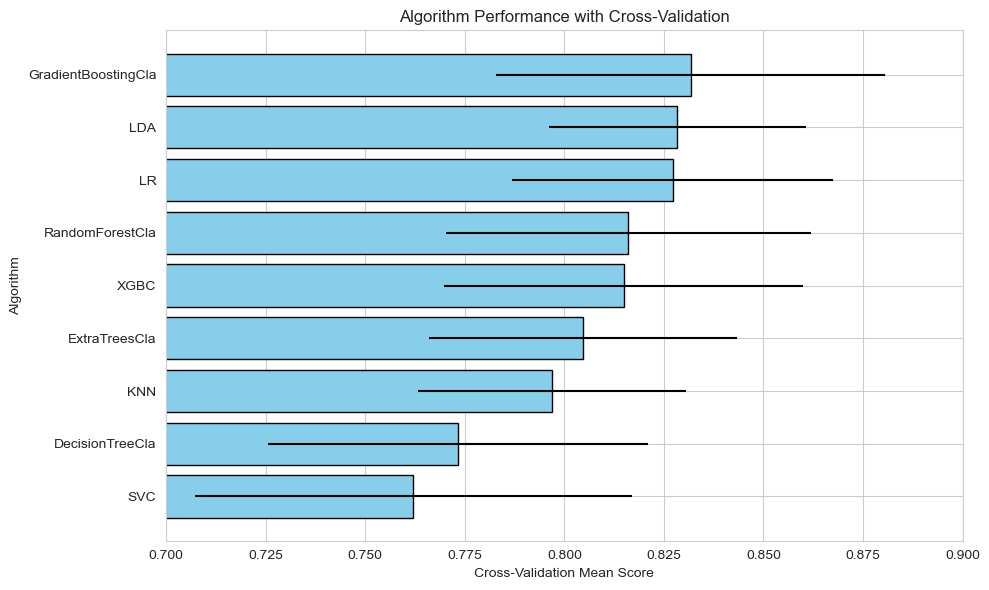

In [48]:
# 排序 DataFrame
sorted_df = cvResDf.sort_values(by='cv_mean', ascending=True)

# 定义 x, y 和 xerr
x = sorted_df['cv_mean']
y = sorted_df['algorithm']
xerr = sorted_df['cv_std'].to_numpy()

# 创建水平条形图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.barh(y=y, width=x, xerr=xerr, color='skyblue', edgecolor='black')  # 使用 Matplotlib 绘制水平条形图

# 设置 x 轴范围
plt.xlim(0.7, 0.9)

# 添加标签和标题
plt.xlabel('Cross-Validation Mean Score')
plt.ylabel('Algorithm')
plt.title('Algorithm Performance with Cross-Validation')

# 显示图形
plt.tight_layout()  # 调整布局防止重叠
plt.show()

In [49]:
# 我们选择 GradientBoostingCla, LR, LDA 三个模型进行进一步调优
# GradientBoostingCla 模型
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['log_loss'],
                 'n_estimators' : [100,200,300],
                 'learning_rate' : [0.1,0.05,0.01],
                 'max_depth' : [4,8],
                 'min_samples_leaf' : [100,150],
                 'max_features' : [0.3,0.1]}
modelgGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold,
                         scoring='accuracy', n_jobs=-1, verbose=1)
modelgGBC.fit(experData_X, experData_y)
modelgGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8395255930087391

<Figure size 640x480 with 0 Axes>

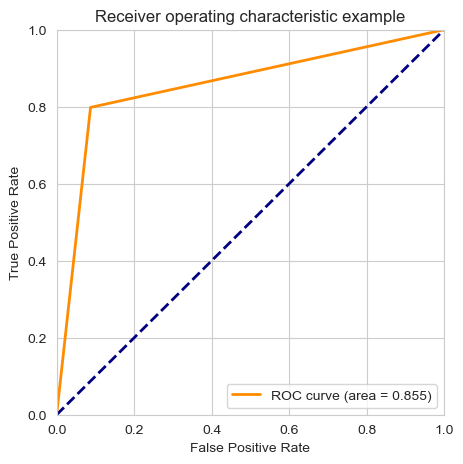

In [50]:
# 模型评估，查看模型 ROC 曲线
# 求出测试数据模型的预测值
modelGBCtestpre_y = modelgGBC.predict(experData_X).astype(int)

# 画图
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(experData_y, modelGBCtestpre_y) # 计算真正率和假正率
roc_auc = auc(fpr, tpr) # 计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

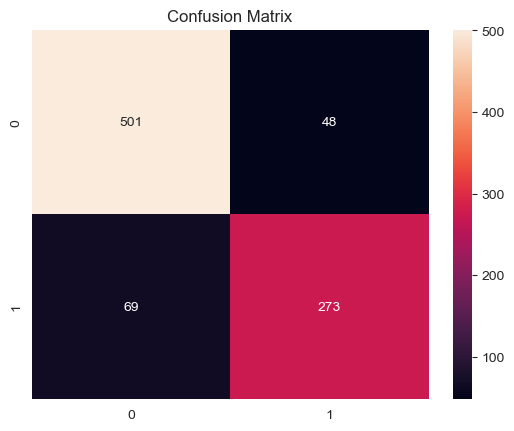

In [52]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(experData_y, modelGBCtestpre_y)
sns.heatmap(cm, annot=True, fmt='d')
_ = plt.title('Confusion Matrix')

In [56]:
# 预测模型
GBCpreData_y = modelgGBC.predict(preData_X)
GBCpreData_y = GBCpreData_y.astype(int)
# 导出预测结果
GBCpreResultDf = pd.DataFrame()
GBCpreResultDf['PassengerId'] = full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived'] = GBCpreData_y
GBCpreResultDf.to_csv('GBCpreResult.csv', index=False)

GBCpreResultDf.head(5)

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
